<a href="https://colab.research.google.com/github/Shiromasteven/Decentralized-Smart-Grid-Demand-Side-Predictions/blob/main/Decentralized_Smart_Energy_Grid_Stability%2C_Final_Production_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Grid Stability - Project 2
##Steven Shiroma
###Date 7/28/22

In [78]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report
from sklearn.decomposition import PCA
from sklearn.metrics import roc_auc_score, RocCurveDisplay
from google.colab import drive
from google.colab import files

filename = ('/content/drive/MyDrive/Project 2/Data_for_UCI_named.csv')

df = pd.read_csv(filename)

In [79]:
def evaluate_classification(model, X_test, y_test, cmap='Greens',
                            normalize=None, classes=None, figsize=(20,5)):
  """Takes as arguments: a model, features, and labels
  Prints a classification report, confusion matrix
  Optional arguments: 
    cmap: colormap 
    normalize: confusion matrix normalization ['true', 'pred', 'all' or None]
    classes: ordered list of class labels
    figsize: size of figure"""
    
  test_preds = model.predict(X_test)
  print(classification_report(y_test, test_preds, target_names=classes))
  
  ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, cmap=cmap, 
                                display_labels=classes,
                                normalize=normalize)
  plt.show()

##Data cleaning

In [80]:
df.head()

,tau1,tau2,tau3,tau4,p1,p2,p3,p4,g1,g2,g3,g4,stab,stabf
0,2.959060,3.079885,8.381025,9.780754,3.763085,-0.782604,-1.257395,-1.723086,0.650456,0.859578,0.887445,0.958034,0.055347,unstable
1,9.304097,4.902524,3.047541,1.369357,5.067812,-1.940058,-1.872742,-1.255012,0.413441,0.862414,0.562139,0.781760,-0.005957,stable
2,8.971707,8.848428,3.046479,1.214518,3.405158,-1.207456,-1.277210,-0.920492,0.163041,0.766689,0.839444,0.109853,0.003471,unstable
3,0.716415,7.669600,4.486641,2.340563,3.963791,-1.027473,-1.938944,-0.997374,0.446209,0.976744,0.929381,0.362718,0.028871,unstable
4,3.134112,7.608772,4.943759,9.857573,3.525811,-1.125531,-1.845975,-0.554305,0.797110,0.455450,0.656947,0.820923,0.049860,unstable


In [81]:
#Checking for duplicates

df.duplicated().sum()

0

In [82]:
#Checking for null values

df.isna().sum()

tau1     0
tau2     0
tau3     0
tau4     0
p1       0
p2       0
p3       0
p4       0
g1       0
g2       0
g3       0
g4       0
stab     0
stabf    0
dtype: int64

In [83]:
#Checking for incorrect string values

df['stabf'].unique()

array(['unstable', 'stable'], dtype=object)

In [84]:
#checking data types are all correct

df.dtypes

tau1     float64
tau2     float64
tau3     float64
tau4     float64
p1       float64
p2       float64
p3       float64
p4       float64
g1       float64
g2       float64
g3       float64
g4       float64
stab     float64
stabf     object
dtype: object

In [85]:
#Iterating through numerical columns to browse for unnatural numbers

for (columnName, columnData) in df.iteritems():
  if columnData.dtype == 'float':
    print('Column Name : ', columnName)
    print('Column Contents : ', columnData.describe())
    print('\n\n')

Column Name :  tau1
Column Contents :  count    10000.000000
mean         5.250000
std          2.742548
min          0.500793
25%          2.874892
50%          5.250004
75%          7.624690
max          9.999469
Name: tau1, dtype: float64



Column Name :  tau2
Column Contents :  count    10000.000000
mean         5.250001
std          2.742549
min          0.500141
25%          2.875140
50%          5.249981
75%          7.624893
max          9.999837
Name: tau2, dtype: float64



Column Name :  tau3
Column Contents :  count    10000.000000
mean         5.250004
std          2.742549
min          0.500788
25%          2.875522
50%          5.249979
75%          7.624948
max          9.999450
Name: tau3, dtype: float64



Column Name :  tau4
Column Contents :  count    10000.000000
mean         5.249997
std          2.742556
min          0.500473
25%          2.874950
50%          5.249734
75%          7.624838
max          9.999443
Name: tau4, dtype: float64



Column Name :  p1
Co

In [86]:
df['stabf'] = df['stabf'].replace({'unstable':0,
                    'stable':1})

df['stabf'].value_counts()

0    6380
1    3620
Name: stabf, dtype: int64

##Data engineer a copy of the DF using averages of the three consumer features


In [87]:
#Create a copied data frame and average the three consumer features of p

de_df = df.copy()

de_df.head()

,tau1,tau2,tau3,tau4,p1,p2,p3,p4,g1,g2,g3,g4,stab,stabf
0,2.959060,3.079885,8.381025,9.780754,3.763085,-0.782604,-1.257395,-1.723086,0.650456,0.859578,0.887445,0.958034,0.055347,0
1,9.304097,4.902524,3.047541,1.369357,5.067812,-1.940058,-1.872742,-1.255012,0.413441,0.862414,0.562139,0.781760,-0.005957,1
2,8.971707,8.848428,3.046479,1.214518,3.405158,-1.207456,-1.277210,-0.920492,0.163041,0.766689,0.839444,0.109853,0.003471,0
3,0.716415,7.669600,4.486641,2.340563,3.963791,-1.027473,-1.938944,-0.997374,0.446209,0.976744,0.929381,0.362718,0.028871,0
4,3.134112,7.608772,4.943759,9.857573,3.525811,-1.125531,-1.845975,-0.554305,0.797110,0.455450,0.656947,0.820923,0.049860,0


In [88]:
de_df = de_df.drop(columns = 'stab')

In [89]:
#Get average of features

de_df['tau_cons_avg'] = (df['tau2'] + df['tau3'] +df['tau4'])/3
de_df = de_df.drop(columns = ['tau4', 'tau2', 'tau3'])

In [90]:
de_df['p_cons_avg'] = (df['p2'] + df['p3'] +df['p4'])/3
de_df = de_df.drop(columns = ['p4', 'p3', 'p2'])

In [91]:
de_df['g_cons_avg'] = (df['g2'] + df['g3'] +df['g4'])/3
de_df = de_df.drop(columns = ['g2', 'g3', 'g4'])

In [92]:
de_df.head()

,tau1,p1,g1,stabf,tau_cons_avg,p_cons_avg,g_cons_avg
0,2.959060,3.763085,0.650456,0,7.080555,-1.254362,0.901686
1,9.304097,5.067812,0.413441,1,3.106474,-1.689271,0.735438
2,8.971707,3.405158,0.163041,0,4.369808,-1.135053,0.571995
3,0.716415,3.963791,0.446209,0,4.832268,-1.321264,0.756281
4,3.134112,3.525811,0.797110,0,7.470035,-1.175270,0.644440


## Data exploration

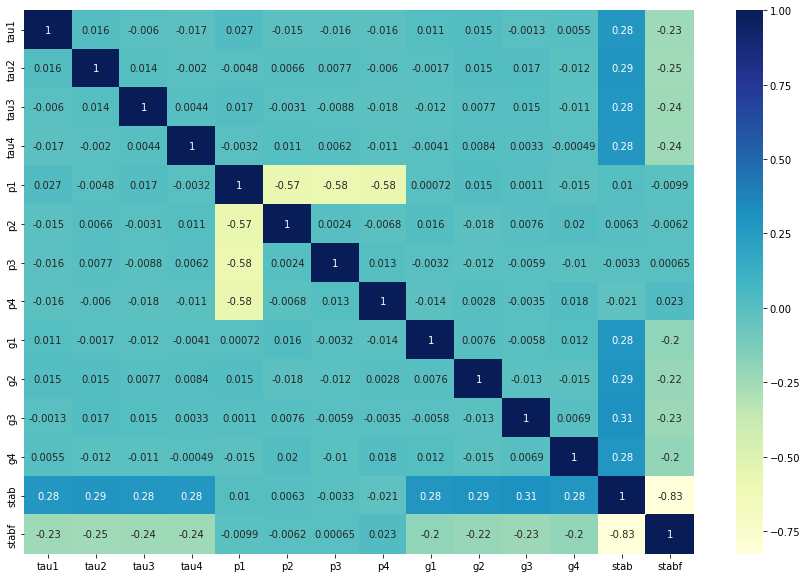

In [93]:
#Create a heatmap table to check for correlations between all the features

corr = df.corr()
fig = plt.figure(figsize = (15,10))
ax = sns.heatmap(corr, annot=True, cmap="YlGnBu")

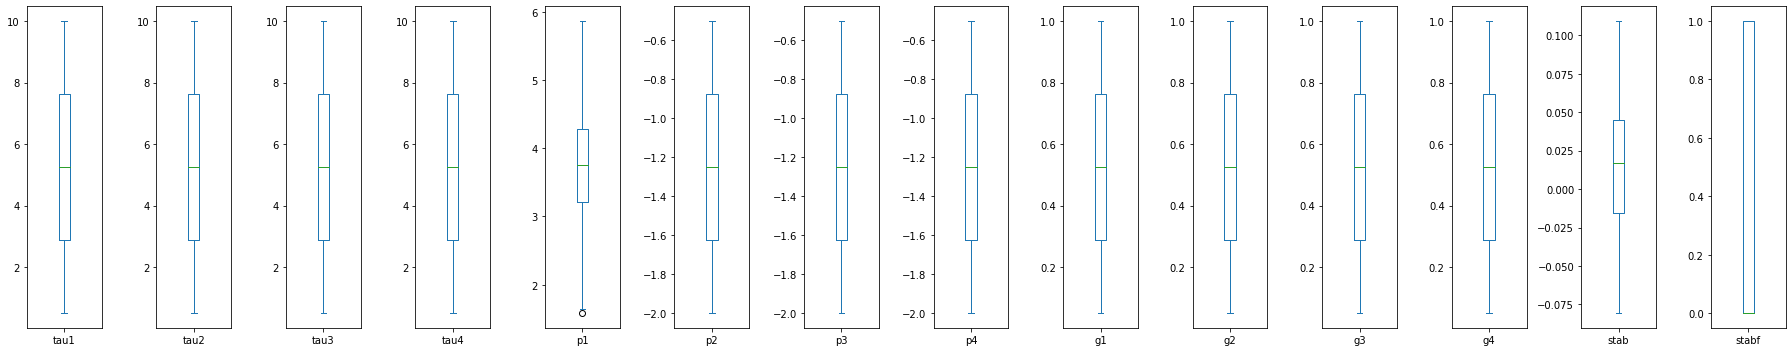

In [94]:
#Create a boxplot to check for outliers

df.plot(kind = 'box', subplots = True, figsize = (25,5))
plt.tight_layout()


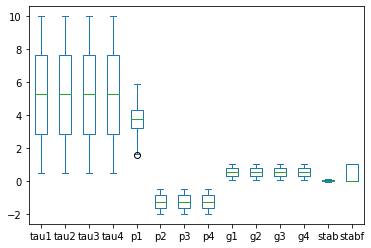

In [95]:
df.plot(kind = 'box')

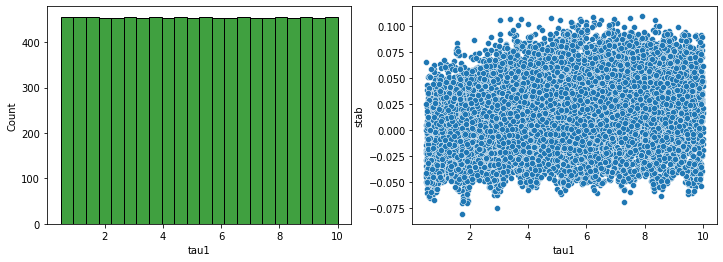

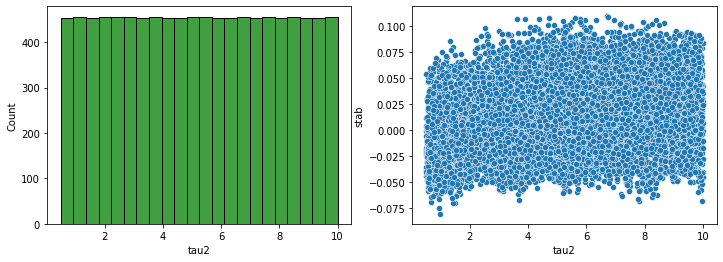

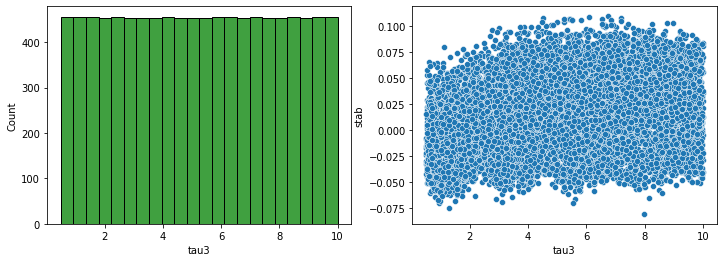

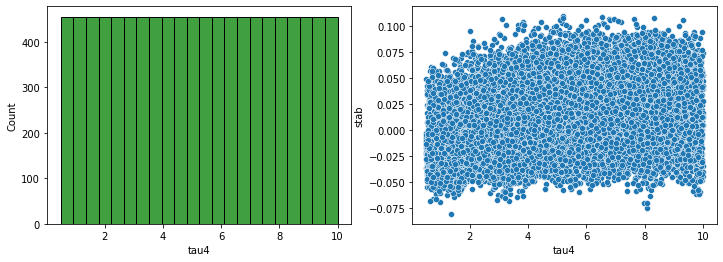

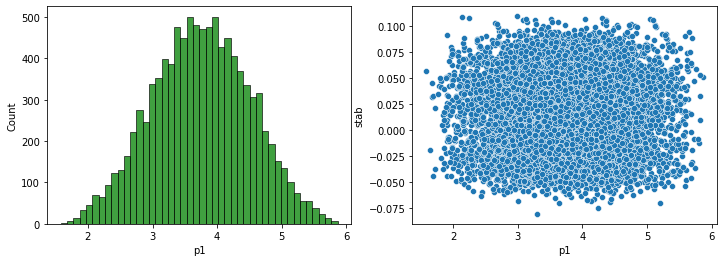

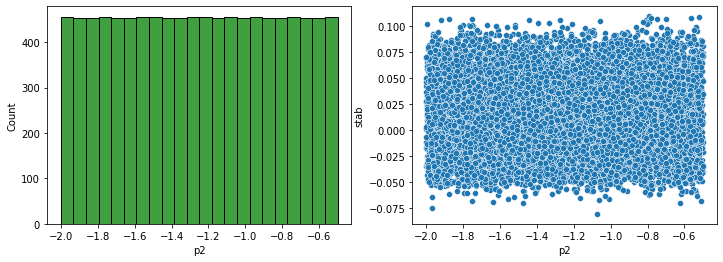

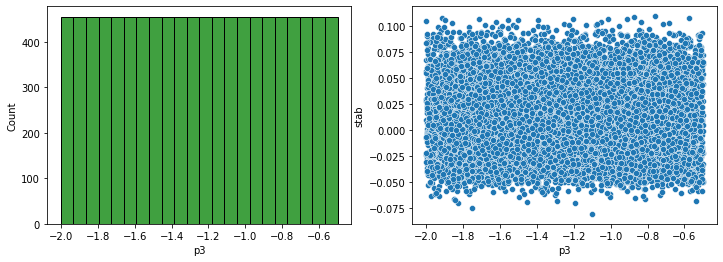

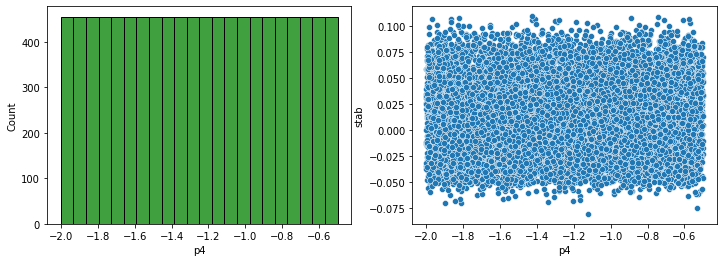

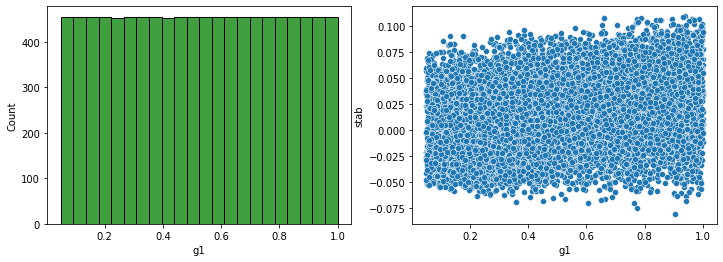

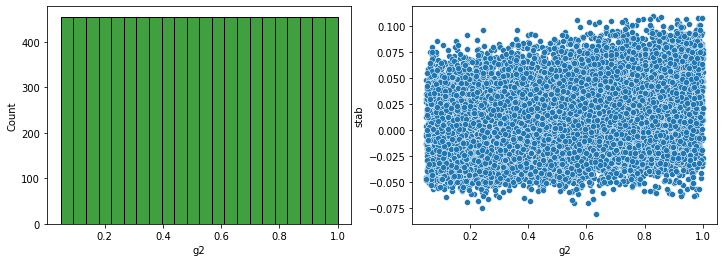

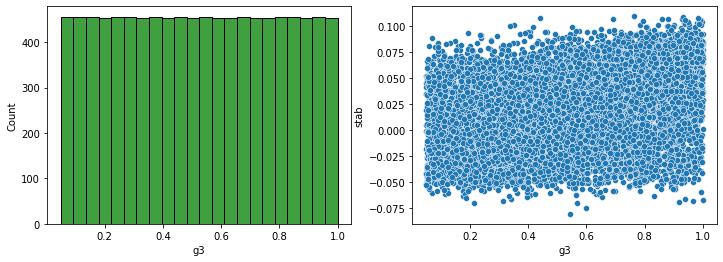

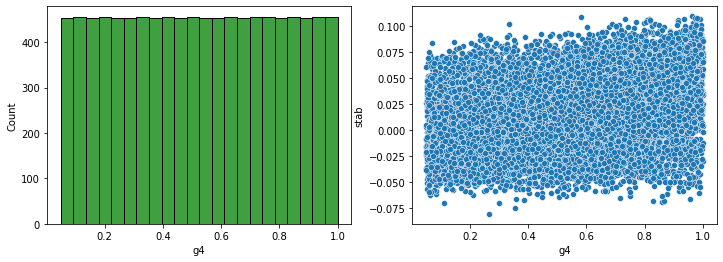

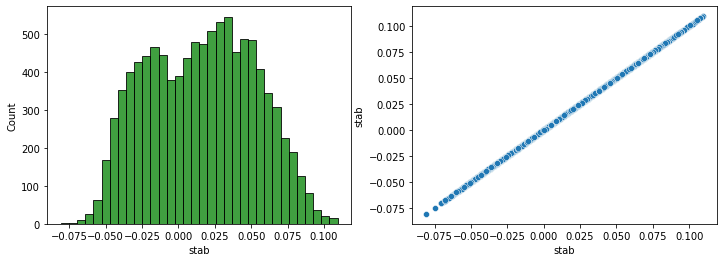

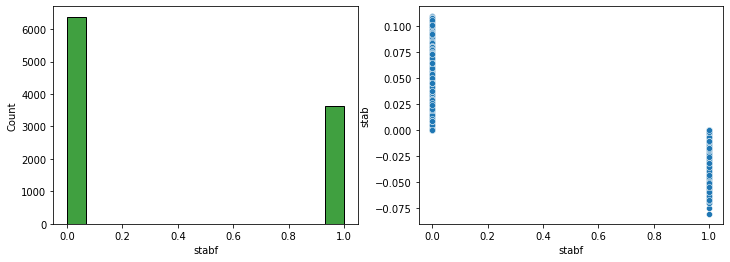

In [96]:
#Create both a scatter and histogram plot for each feature

for column in df:
  plot_fig, plot_axes = plt.subplots(1,2, figsize = (12,4))
  chart_1 = sns.histplot(x=df[column], ax = plot_axes[0], color ='g')

  chart_2 = sns.scatterplot(x = column, y = 'stab', data = df, ax = plot_axes[1])

  plt.show()

In [97]:
#Create stacked, paired barplot.
#Gather features and average each one.

df_p1 = df['p1']
df_p2 = df['p2']
df_p3 = df['p3']
df_p4 = df['p4']

In [98]:
df_p1_mean = df['p1'].mean()
df_p2_mean = abs(df['p2'].mean())
df_p3_mean = abs(df['p3'].mean())
df_p4_mean = abs(df['p4'].mean())

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

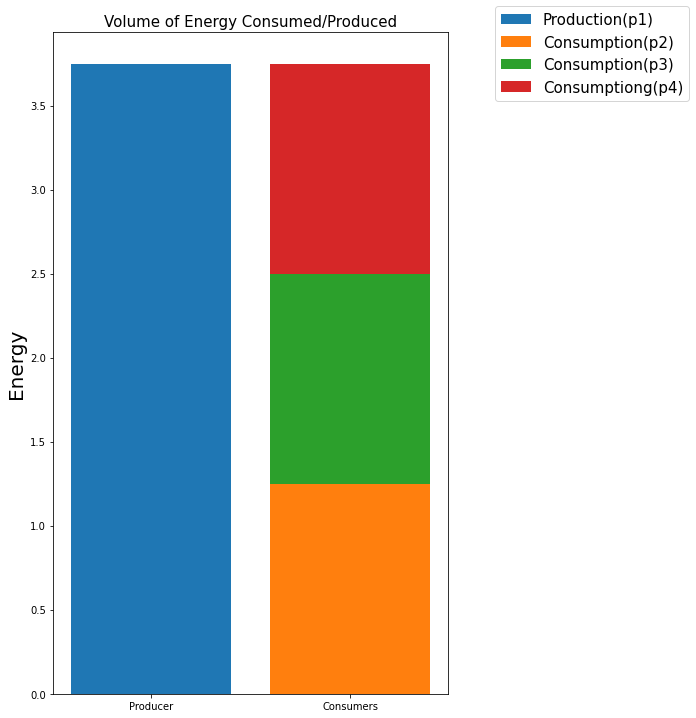

In [99]:
#Plot paired, stacked barplot

width = ['Producer', 'Consumers']  # the width of the bars

fig, ax = plt.subplots(figsize = (10,10))
rects1 = ax.bar(width[0], df_p1_mean, label='Production(p1)')
rects2 = ax.bar(width[1], df_p2_mean, label='Consumption(p2)')
rects3 = ax.bar(width[1], df_p3_mean, bottom = df_p2_mean,
                label='Consumption(p3)')
rects4 = ax.bar(width[1], df_p4_mean, bottom = df_p2_mean + df_p3_mean,
                label='Consumptiong(p4)')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Energy', fontsize = 20)
ax.set_title('Volume of Energy Consumed/Produced', fontsize = 15)
ax.set_xticks(['Producer', 'Consumers'])
ax.legend(bbox_to_anchor=(1.1, 1.05), fontsize = 15)



fig.tight_layout()

plt.savefig('Volume of Energy Consumed or Produced.png',  bbox_inches="tight")

files.download('Volume of Energy Consumed or Produced.png')

plt.show()



This plot shows the trend of balancing the amoutn of energy produced is evenly distributed across three consumers. This is important to note because of the nature of the 4 node star grid should optimally reach equilibrium.

In [100]:
#Create visualization that describes the best conditions for grid stability

#Create filter for above and below 0 (0 being the cuttoff point of grid stability)

df_stable_filter = df['stab'] <= 0.0

In [101]:
df_stable = df.loc[df_stable_filter.value_counts(), :]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

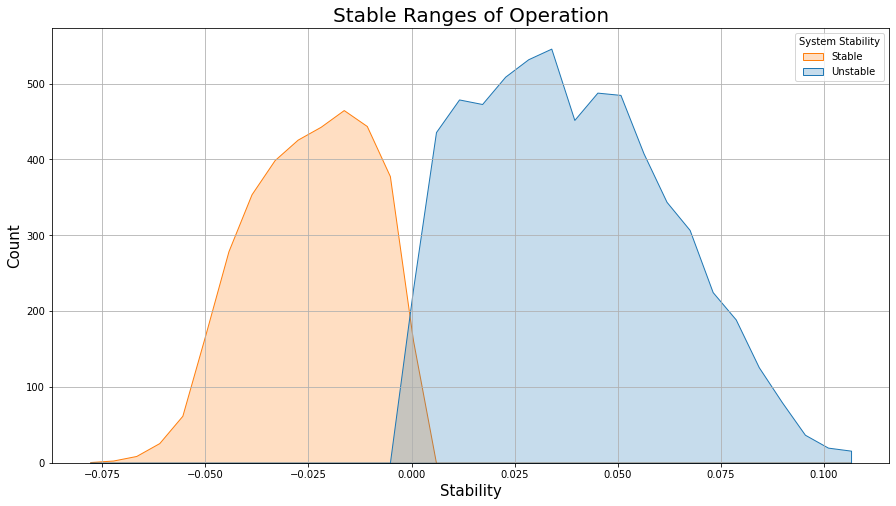

In [102]:
#Plot and show

plt.figure(figsize=(15,8))
p = sns.histplot(x=df['stab'], hue = df_stable_filter, element = 'poly')
p.set_title('Stable Ranges of Operation', fontsize = 20)
p.set_xlabel('Stability', fontsize = 15)
p.set_ylabel('Count', fontsize = 15)
plt.legend(labels=["Stable","Unstable"], title = 'System Stability', fontsize = 10)
plt.grid()

plt.savefig('Stable_ranges_of_Operation.png',  bbox_inches="tight")

files.download('Stable_ranges_of_Operation.png')

plt.show()

This graph shows the ranges of operation for the grid where optimal stable conditions are met. Here we can see where peak operating conditions and tolerances should be kept.

#Modeling

##Decision Tree classifier

In [103]:
#Create decision tree model
#Train test split

X = df.drop(columns = ['stabf', 'stab'])

y = df['stabf']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

In [104]:
#Instantiate variables
#fit, transform and make pipeline


dec_tree_class = DecisionTreeClassifier(random_state = 42)

scaler = StandardScaler()

X_train_processed = scaler.fit_transform(X_train)

X_test_processed = scaler.fit_transform(X_test)

dec_tree_pipe = make_pipeline(scaler, dec_tree_class)

dec_tree_pipe.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(random_state=42))])

In [105]:
#Evaluate metrics

print(dec_tree_pipe.score(X_train, y_train))
print(dec_tree_pipe.score(X_test, y_test))

1.0
0.8536


              precision    recall  f1-score   support

           0       0.90      0.87      0.89      1630
           1       0.77      0.82      0.80       870

    accuracy                           0.85      2500
   macro avg       0.84      0.85      0.84      2500
weighted avg       0.86      0.85      0.85      2500



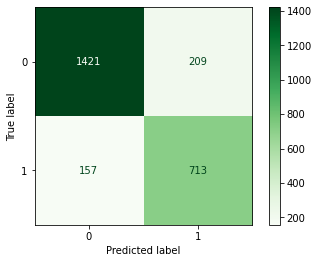

In [106]:
evaluate_classification(dec_tree_pipe, X_test, y_test)

###Decision tree tuning

####Trial one

In [107]:
#fit model

dec_tree = DecisionTreeClassifier(random_state = 42)

dec_tree.fit(X_train_processed, y_train)

dec_tree.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': 42,
 'splitter': 'best'}

In [108]:
#fit model

dec_tree.fit(X_train_processed, y_train)

#set parameters
param_grid = {'max_depth':[2,3,4],
              'min_samples_split': [2,3,4],
              }

#Cross Validate
dec_tree_grid_search = GridSearchCV(dec_tree, param_grid)

In [109]:
dec_tree_grid_search.fit(X_train_processed, y_train)
dec_tree_grid_search.best_params_

{'max_depth': 4, 'min_samples_split': 2}

In [110]:
#Evaluate Scores

best_model = dec_tree_grid_search.best_estimator_
best_model.fit(X_train_processed, y_train)
best_model.score(X_test_processed, y_test)

0.7592

####Trial 2

In [111]:
#fit model

dec_tree.fit(X_train_processed, y_train)

#set parameters

param_grid2 = {'max_depth':[4,5,6,7],
              'min_samples_split': [2,3,4],
              }

#Cross Validate

dec_tree_grid_search2 = GridSearchCV(dec_tree, param_grid2)

In [112]:
dec_tree_grid_search2.fit(X_train_processed, y_train)
dec_tree_grid_search2.best_params_

{'max_depth': 7, 'min_samples_split': 4}

In [113]:
#Evaluate Scores

best_model = dec_tree_grid_search2.best_estimator_
best_model.fit(X_train_processed, y_train)
best_model.score(X_test_processed, y_test)

0.8444

####Trial 3

In [114]:
#fit model

dec_tree.fit(X_train_processed, y_train)

#set parameters

param_grid3 = {'max_depth':[7,8,9,10],
              'min_samples_split': [2,3,4,5,6,7],
              }

#Cross Validate

dec_tree_grid_search3 = GridSearchCV(dec_tree, param_grid3)

In [115]:
dec_tree_grid_search3.fit(X_train_processed, y_train)
dec_tree_grid_search3.best_params_

{'max_depth': 10, 'min_samples_split': 4}

In [116]:
#Evaluate Scores

best_model = dec_tree_grid_search3.best_estimator_
best_model.fit(X_train_processed, y_train)
best_model.score(X_test_processed, y_test)

0.8548

###Decision tree with Engineering

In [117]:
#Evaluate model use with engineered data set

#Train test split

X = de_df.drop(columns = 'stabf')

y = de_df['stabf']

(X_train, X_test, y_train, y_test) = train_test_split(X, y, random_state=42)

#Fit model

dec_tree_pipe.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(random_state=42))])

In [118]:
#Evaluate Scores

print(dec_tree_pipe.score(X_train, y_train))
print(dec_tree_pipe.score(X_test, y_test))

1.0
0.8132


              precision    recall  f1-score   support

           0       0.87      0.84      0.85      1630
           1       0.71      0.77      0.74       870

    accuracy                           0.81      2500
   macro avg       0.79      0.80      0.80      2500
weighted avg       0.82      0.81      0.81      2500



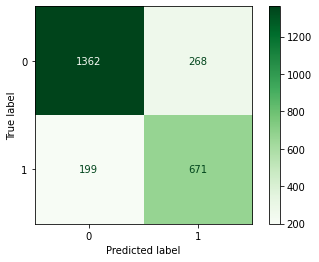

In [119]:
#Evaluate Metrics

evaluate_classification(dec_tree_pipe, X_test, y_test)

###Decision Tree PCA

In [120]:
#Evaluate model use with PCA

X = df.drop(columns = ['stab', 'stabf'])
y = df['stabf']

scaler = StandardScaler()

#Fit pca to df

scaled_df = scaler.fit_transform(X)
pca = PCA()
pca.fit(scaled_df)

PCA()

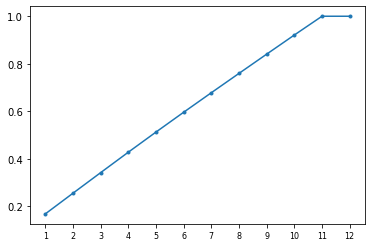

In [121]:


plt.plot(range(1, 13), pca.explained_variance_ratio_.cumsum(), marker= '.')
plt.xticks(ticks=range(1,13), fontsize=8);

Text(0, 0.5, 'Proportion of Explained Variance')

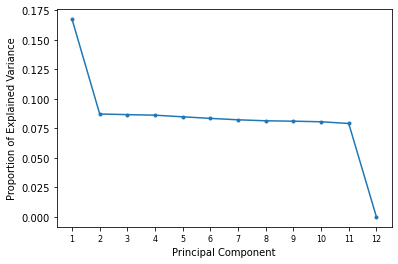

In [122]:
plt.plot(range(1, 13), pca.explained_variance_ratio_, marker = '.')
plt.xticks(ticks = range(1, 13), fontsize=8)
plt.xlabel('Principal Component')
plt.ylabel('Proportion of Explained Variance')

In [123]:
pca2 = PCA(n_components=2)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
transformer = make_pipeline(StandardScaler(), PCA(n_components=2))
dec_tree = DecisionTreeClassifier()
dec_tree_pipe = make_pipeline(transformer, dec_tree)
dec_tree_pipe.fit(X_train, y_train
                  )

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('standardscaler', StandardScaler()),
                                 ('pca', PCA(n_components=2))])),
                ('decisiontreeclassifier', DecisionTreeClassifier())])

In [124]:
print('Training accuracy:', dec_tree_pipe.score(X_train, y_train))
print('Testing accuracy:', dec_tree_pipe.score(X_test, y_test))

Training accuracy: 1.0
Testing accuracy: 0.6052


##Bagged Tree Classifier

In [125]:
#Evaluate a bagged tree model

#train test split

X = df.drop(columns = ['stabf', 'stab'])

y = df['stabf']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

#make and fit a pipeline

bag_tree_class = BaggingClassifier()

bag_pipe = make_pipeline(scaler, bag_tree_class)

bag_pipe.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('baggingclassifier', BaggingClassifier())])

In [126]:
#evaluate scores

print(bag_pipe.score(X_train, y_train))
print(bag_pipe.score(X_test, y_test))

0.9942666666666666
0.8964


              precision    recall  f1-score   support

           0       0.91      0.94      0.92      1630
           1       0.87      0.82      0.85       870

    accuracy                           0.90      2500
   macro avg       0.89      0.88      0.88      2500
weighted avg       0.90      0.90      0.90      2500



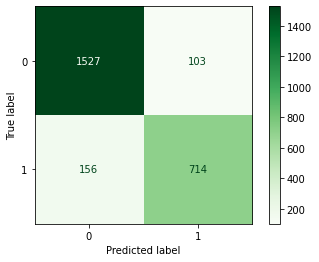

In [127]:
#evaluate metrics

evaluate_classification(bag_pipe, X_test, y_test)

###Bagged Tree Tuning

####Trial 1

In [128]:
#instantiate model 

bag_tree = BaggingClassifier(random_state = 42)

#fit

bag_tree.fit(X_train_processed, y_train)

#list tuning parameters

bag_tree.get_params()

{'base_estimator': None,
 'bootstrap': True,
 'bootstrap_features': False,
 'max_features': 1.0,
 'max_samples': 1.0,
 'n_estimators': 10,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

In [129]:
#use gridsearch cv to find best parameters

param_grid = {'n_estimators': [10,20,30,40,50]}

bag_tree_grid_search = GridSearchCV(bag_tree, param_grid)

In [130]:


bag_tree_grid_search.fit(X_train_processed, y_train)
bag_tree_grid_search.best_params_

{'n_estimators': 50}

In [131]:
#evaluate score

best_model = bag_tree_grid_search.best_estimator_
best_model.fit(X_train_processed, y_train)
best_model.score(X_test_processed, y_test)

0.902

####trial 2

In [132]:
#use gridsearch cv to find best parameters

param_grid2 = {'n_estimators': [50, 60, 70, 80]}

bag_tree_grid_search2 = GridSearchCV(bag_tree, param_grid2)

In [133]:
bag_tree_grid_search2.fit(X_train_processed, y_train)
bag_tree_grid_search2.best_params_

{'n_estimators': 80}

In [134]:
#Evaluate score

best_model = bag_tree_grid_search2.best_estimator_
best_model.fit(X_train_processed, y_train)
best_model.score(X_test_processed, y_test)

0.9052

####Bagged tree classifier with feature engineering

In [135]:
#Evaluate bagged tree model with engineered dataset

#train test split

X = de_df.drop(columns = 'stabf')

y = de_df['stabf']

(X_train, X_test, y_train, y_test) = train_test_split(X, y, random_state=42)

In [136]:
#fit

bag_pipe.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('baggingclassifier', BaggingClassifier())])

In [137]:
#evaluate scores

print(bag_pipe.score(X_train, y_train))
print(bag_pipe.score(X_test, y_test))

0.9882666666666666
0.8364


              precision    recall  f1-score   support

           0       0.86      0.89      0.88      1630
           1       0.78      0.73      0.76       870

    accuracy                           0.84      2500
   macro avg       0.82      0.81      0.82      2500
weighted avg       0.83      0.84      0.84      2500



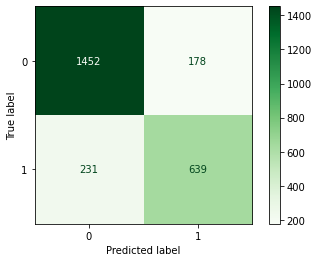

In [138]:
#evaluate metrics

evaluate_classification(bag_pipe, X_test, y_test)

###Bagged Tree PCA

In [139]:
#Evaluate bagged tree with PCA

#instantiate variables and PCA

X = df.drop(columns = ['stab', 'stabf'])
y = df['stabf']

scaler = StandardScaler()

scaled_df = scaler.fit_transform(X)
pca = PCA()

#fit pca

pca.fit(scaled_df)

PCA()

In [140]:
pca2 = PCA(n_components=2)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
transformer = make_pipeline(StandardScaler(), PCA(n_components=2))
bag_tree = BaggingClassifier()
bag_tree_pipe = make_pipeline(transformer, bag_tree)
bag_tree_pipe.fit(X_train, y_train
                  )

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('standardscaler', StandardScaler()),
                                 ('pca', PCA(n_components=2))])),
                ('baggingclassifier', BaggingClassifier())])

In [141]:
print('Training accuracy:', bag_tree_pipe.score(X_train, y_train))
print('Testing accuracy:', bag_tree_pipe.score(X_test, y_test))

Training accuracy: 0.9684
Testing accuracy: 0.6488


## Random Forest classifier

In [142]:
#Evaluate a random forest model

#Train test split

X = df.drop(columns = ['stabf', 'stab'])

y = df['stabf']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

#instantiate model, make and fit pipeline

rand_forest_class = RandomForestClassifier(random_state = 42)

rf = make_pipeline(scaler, rand_forest_class)

rf.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('randomforestclassifier',
                 RandomForestClassifier(random_state=42))])

In [143]:
#Evaluate scores

print(rf.score(X_train, y_train))
print(rf.score(X_test, y_test))

1.0
0.9116


              precision    recall  f1-score   support

           0       0.93      0.94      0.93      1630
           1       0.88      0.86      0.87       870

    accuracy                           0.91      2500
   macro avg       0.91      0.90      0.90      2500
weighted avg       0.91      0.91      0.91      2500



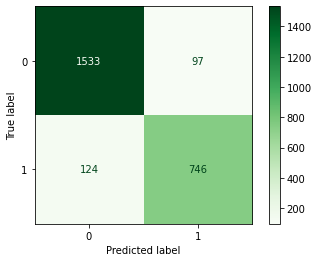

In [144]:
#evalute metrics

evaluate_classification(rf, X_test, y_test)

###Random Forest Tuning


####Trial 1

In [145]:
#Tune hyperparameters for random forest model

#instantiate and fit model, then get tuning parameters

rf = RandomForestClassifier(random_state = 42)
rf.fit(X_train, y_train)

rf.get_params()


{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

In [146]:
#instantiate model, build parameter grid and cross validate

model = RandomForestClassifier(random_state = 42)

param_grid = {'max_depth':[2,3,4],
              'min_samples_split': [2,3,4],
              'n_estimators': [50,80,100]}

rf_grid_search = GridSearchCV(model, param_grid)

In [147]:
rf_grid_search.fit(X_train_processed, y_train)
rf_grid_search.best_params_

{'max_depth': 4, 'min_samples_split': 2, 'n_estimators': 50}

In [148]:
best_model = rf_grid_search.best_estimator_
best_model.fit(X_train_processed, y_train)
best_model.score(X_test_processed, y_test)

0.8364

####Trial 2

In [149]:
#build parameter grid and cross validate

param_grid2 = {'max_depth':[3,4,5],
              'min_samples_split': [3,4,5],
              'n_estimators': [70,80,90,100]}

rf_grid_search2 = GridSearchCV(model, param_grid2)

In [150]:
rf_grid_search2.fit(X_train_processed, y_train)
rf_grid_search2.best_params_

{'max_depth': 5, 'min_samples_split': 5, 'n_estimators': 90}

In [151]:
#Evaluate score

best_model = rf_grid_search2.best_estimator_
best_model.fit(X_train_processed, y_train)
best_model.score(X_test_processed, y_test)

0.8536

####Trial 3

In [152]:
#build parameter grid and cross validate

param_grid3 = {'max_depth':[4,5,6,7],
              'min_samples_split': [2,3,4,5],
              'n_estimators': [100,120,140]}

rf_grid_search3 = GridSearchCV(model, param_grid3)

In [153]:
rf_grid_search3.fit(X_train_processed, y_train)
rf_grid_search3.best_params_

{'max_depth': 7, 'min_samples_split': 4, 'n_estimators': 140}

In [154]:
#evaluate score

best_model = rf_grid_search3.best_estimator_
best_model.fit(X_train_processed, y_train)
best_model.score(X_test_processed, y_test)

0.8884

####Trial 4

In [155]:
#build parameter grid and cross validate

param_grid4 = {'max_depth':[7,8,9,10],
              'min_samples_split': [2,3,4,5],
              'n_estimators': [140,160,180,200]}

rf_grid_search4 = GridSearchCV(model, param_grid4)

In [156]:
rf_grid_search4.fit(X_train_processed, y_train)
rf_grid_search4.best_params_

{'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 140}

In [157]:
%%time

#evalute score

final_best_model = rf_grid_search4.best_estimator_
final_best_model.fit(X_train_processed, y_train)
final_best_model.score(X_test_processed, y_test)

CPU times: user 2.93 s, sys: 7.46 ms, total: 2.94 s
Wall time: 2.95 s


              precision    recall  f1-score   support

           0       0.91      0.95      0.93      1630
           1       0.90      0.82      0.86       870

    accuracy                           0.91      2500
   macro avg       0.91      0.89      0.89      2500
weighted avg       0.91      0.91      0.90      2500



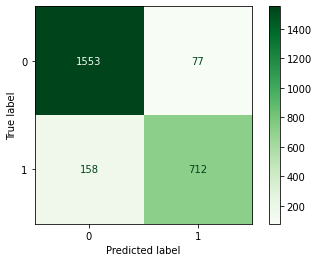

In [158]:
#evalute metrics

evaluate_classification(final_best_model, X_test_processed, y_test)

In [159]:


X = df.drop(columns = ['stabf', 'stab'])

y = df['stabf']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

rand_forest_class = RandomForestClassifier(random_state = 42, max_depth = 10, min_samples_split = 5, n_estimators = 140)

rf = make_pipeline(scaler, rand_forest_class)

rf.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('randomforestclassifier',
                 RandomForestClassifier(max_depth=10, min_samples_split=5,
                                        n_estimators=140, random_state=42))])

In [160]:
print(rf.score(X_train, y_train))
print(rf.score(X_test, y_test))

0.9908
0.9076


              precision    recall  f1-score   support

           0       0.91      0.95      0.93      1630
           1       0.89      0.83      0.86       870

    accuracy                           0.91      2500
   macro avg       0.90      0.89      0.90      2500
weighted avg       0.91      0.91      0.91      2500



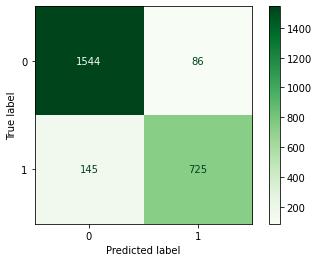

In [161]:
evaluate_classification(rf, X_test, y_test)

###Random Forest with feature engineering


In [162]:
#Evaluate random forest model using the egineered data set

#Train test split

X = de_df.drop(columns = 'stabf')

y = de_df['stabf']

(X_train, X_test, y_train, y_test) = train_test_split(X, y, random_state=42)

In [163]:
#fit

rf.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('randomforestclassifier',
                 RandomForestClassifier(max_depth=10, min_samples_split=5,
                                        n_estimators=140, random_state=42))])

In [164]:
#evaluate scores

print(rf.score(X_train, y_train))
print(rf.score(X_test, y_test))

0.924
0.8624


              precision    recall  f1-score   support

           0       0.89      0.91      0.90      1630
           1       0.82      0.78      0.80       870

    accuracy                           0.86      2500
   macro avg       0.85      0.84      0.85      2500
weighted avg       0.86      0.86      0.86      2500



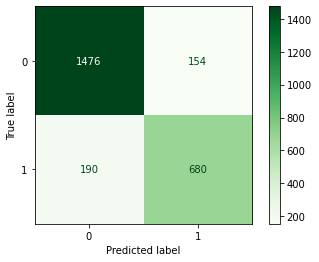

In [165]:
#Evalute metrics

evaluate_classification(rf, X_test, y_test)

### Random Forest PCA

In [166]:
#Evaluate a random forest model using PCA

X = df.drop(columns =['stabf', 'stab'])
y = df['stabf']

X.shape

(10000, 12)

In [167]:
#Instantiate and fit PCA

scaler = StandardScaler()

scaled_df = scaler.fit_transform(X)

pca = PCA()
pca.fit(scaled_df)

PCA()

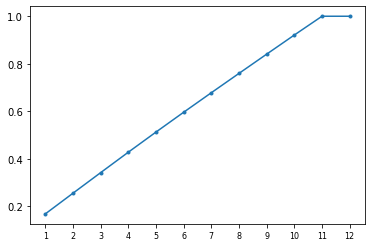

In [168]:
plt.plot(range(1, 13), pca.explained_variance_ratio_.cumsum(), marker= '.')
plt.xticks(ticks=range(1,13), fontsize=8);

Text(0, 0.5, 'Proportion of Explained Variance')

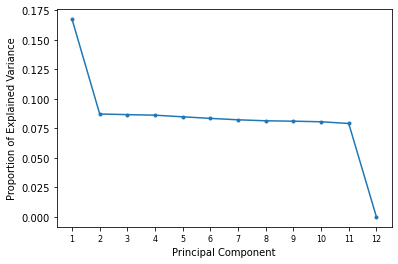

In [169]:
plt.plot(range(1, 13), pca.explained_variance_ratio_, marker = '.')
plt.xticks(ticks = range(1, 13), fontsize=8)
plt.xlabel('Principal Component')
plt.ylabel('Proportion of Explained Variance')

In [170]:
pca2 = PCA(n_components = 2)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

transformer = make_pipeline(StandardScaler(), PCA(n_components=7))

RF = RandomForestClassifier()

rf_pipe = make_pipeline(transformer, rf)

rf_pipe.fit(X_train, y_train)

Pipeline(steps=[('pipeline-1',
                 Pipeline(steps=[('standardscaler', StandardScaler()),
                                 ('pca', PCA(n_components=7))])),
                ('pipeline-2',
                 Pipeline(steps=[('standardscaler', StandardScaler()),
                                 ('randomforestclassifier',
                                  RandomForestClassifier(max_depth=10,
                                                         min_samples_split=5,
                                                         n_estimators=140,
                                                         random_state=42))]))])

In [171]:
print('Training accuracy:', rf_pipe.score(X_train, y_train))
print('Testing accuracy:', rf_pipe.score(X_test, y_test))

Training accuracy: 0.9041333333333333
Testing accuracy: 0.8132


##Logistic Regression model

In [172]:
#Evaluate a logistic regression model

#Instantiate model, and fit

log_reg = LogisticRegression()

log_reg_pipe = make_pipeline(scaler,log_reg)

log_reg_pipe.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression', LogisticRegression())])

In [173]:
#Evaluate scores

print(log_reg_pipe.score(X_train, y_train))
print(log_reg_pipe.score(X_test, y_test))

0.8170666666666667
0.812


              precision    recall  f1-score   support

           0       0.85      0.86      0.86      1630
           1       0.74      0.71      0.73       870

    accuracy                           0.81      2500
   macro avg       0.79      0.79      0.79      2500
weighted avg       0.81      0.81      0.81      2500



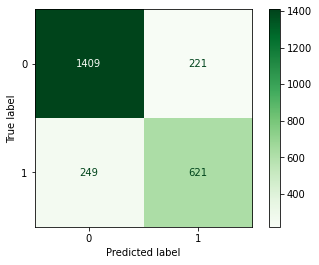

In [174]:
#Evaluate Metrics

evaluate_classification(log_reg_pipe, X_test, y_test)

### Logistic Regression with feature engineering

In [175]:
#Evalute logistic regression with the engineered features

#train test split

X = de_df.drop(columns = 'stabf')

y = de_df['stabf']

(X_train, X_test, y_train, y_test) = train_test_split(X, y, random_state=42)

In [176]:
#Instantiate and fit pipeline

log_reg_pipe = make_pipeline(scaler,log_reg)

log_reg_pipe.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression', LogisticRegression())])

In [177]:
#Evaluate scores

print(log_reg_pipe.score(X_train, y_train))
print(log_reg_pipe.score(X_test, y_test))

0.8170666666666667
0.808


              precision    recall  f1-score   support

           0       0.85      0.86      0.85      1630
           1       0.73      0.71      0.72       870

    accuracy                           0.81      2500
   macro avg       0.79      0.78      0.79      2500
weighted avg       0.81      0.81      0.81      2500



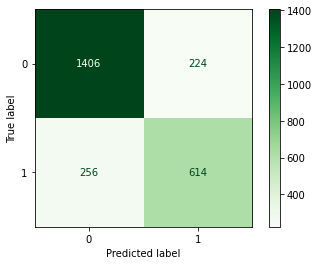

In [178]:
#Evaluate Metrics

evaluate_classification(log_reg_pipe, X_test, y_test)

#Production Model

              precision    recall  f1-score   support

           0       0.91      0.95      0.93      1630
           1       0.90      0.82      0.86       870

    accuracy                           0.91      2500
   macro avg       0.91      0.89      0.89      2500
weighted avg       0.91      0.91      0.90      2500



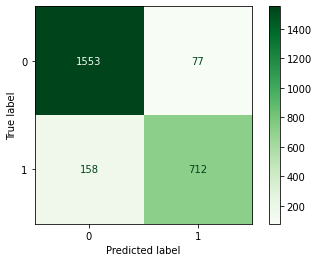

In [179]:
evaluate_classification(final_best_model, X_test_processed, y_test)

In [180]:
print(f'Training AUC: {roc_auc_score(y_train, final_best_model.predict_proba(X_train_processed)[:,1])}')
print(f'Testing AUC: {roc_auc_score(y_test, final_best_model.predict_proba(X_test_processed)[:,1])}')

Training AUC: 0.9998977224880383
Testing AUC: 0.971442070375855


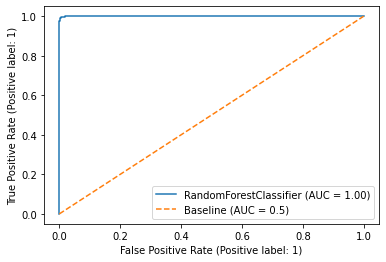

In [181]:
RocCurveDisplay.from_estimator(final_best_model, X_train_processed, y_train)
plt.plot([0, 1], [0, 1], ls = '--', label = 'Baseline (AUC = 0.5)')
plt.legend();

For predicting the stability of a decentralized smart grid I recommend the use of my final production model, A tuned random forest model. For this particular case I have selected the model which has the most accuracy and with the lower rate of false positive for more accurate detection of instability which would be more beneficial in the case of premptively adjusting consumer usage or production.